In [54]:
import pickle
import os
import sys

In [2]:
from collections import defaultdict
from utils.dict_utils import dict_to_defaultdict

In [1520]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.legend_handler import HandlerTuple

plt.rcParams.update({'font.size': 18})

In [1885]:
dataset = 'cifar2_binary'
num_classes = 2
# dataset = 'mnist'
# num_classes = 10
train_size = 1000
num_hidden = 1
bias = False
normalization = 'none'
activation = 'lrelu'
optimizer = 'sgd'
optimizer_name = 'GD' if optimizer == 'sgd' else 'RMSProp' if optimizer == 'rmsprop' else optimizer
num_seeds = 5
num_epochs = 500
batch_size = 1000
lr = 0.02

In [1886]:
log_dir = os.path.join(
    'results', 'ref_width_dependence', '{}_{}'.format(dataset, train_size), 
    'num_hidden={}_activation={}_bias={}_normalization={}'.format(num_hidden, activation, bias, normalization), 
    '{}_lr={}_batch_size={}_num_epochs={}'.format(optimizer, lr, batch_size, num_epochs)
)
log_dir

'results/ref_width_dependence/cifar2_binary_1000/num_hidden=1_activation=lrelu_bias=False_normalization=none/sgd_lr=0.02_batch_size=1000_num_epochs=500'

In [1894]:
results_all_path = os.path.join(log_dir, 'results_all.dat')
results_all = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan))))))
if os.path.exists(results_all_path):
    with open(results_all_path, 'rb') as f:
        results_all = dict_to_defaultdict(pickle.load(f), results_all)

In [1888]:
correction_epochs = [0]
if num_hidden == 1:
    real_widths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
    scaling_modes = ['mean_field', 'ntk', 'intermediate_q=0.75', 'default']
    scaling_mode_names = ['MF', 'NTK', r'intermediate; $q_\sigma=-3/4$', 'default']
    #scaling_modes = ['mean_field', 'ntk', 'default']
    #scaling_mode_names = ['MF', 'NTK', 'default']
    ref_widths = [128]
elif num_hidden == 2:
    real_widths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
    scaling_modes = ['mean_field', 'ntk', 'default']
    scaling_mode_names = ['MF', 'NTK', 'default']
    ref_widths = [128]
else:
    real_widths = [128, 256, 512, 1024, 2048, 4096, 8192]
    scaling_modes = ['mean_field', 'ntk', 'default']
    scaling_mode_names = ['MF', 'NTK', 'default']
    ref_widths = [128]
    

In [1875]:
show_default = True

In [1844]:
def ewma(a, alpha):
    av_a = a
    for i in range(1, len(a)):
        av_a[i] = a[i] * alpha + av_a[i-1] * (1-alpha)
    return av_a

In [1845]:
def draw_curve(scaling_mode, ref_width, correction_epoch, key, 
               q=0, idx=None, scale=1, threshold=1000, smoothening_factor=0, **kwargs):
    widths = real_widths if ref_width is None else [width for width in real_widths if width >= ref_width]
    if idx is None:
        data = [
            [
                results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] 
                for real_width in widths
            ] for seed in range(num_seeds)
        ]
    else:
        data = [
            [
                results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx] 
                for real_width in widths
            ] for seed in range(num_seeds)
        ]
    data = np.array(data)
    data = data * scale * np.power(widths, q)
    data = np.clip(data, -threshold, threshold)
    data = np.exp(ewma(np.log(data.T)[::-1], alpha=1-smoothening_factor)[::-1].T)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plot, = plt.plot(np.log2(widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )
    return plot

In [1897]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (1,5)), (0, (3,5))]
cmap = plt.get_cmap('tab10')
key_bases = ['test_loss', 'test_acc', 'train_loss', 'train_acc']
key_modifiers = [('final_', '')]
ylims = [(0.34,0.48), (0.75, 0.85), (0.0,0.7), (0.7,1.0)]

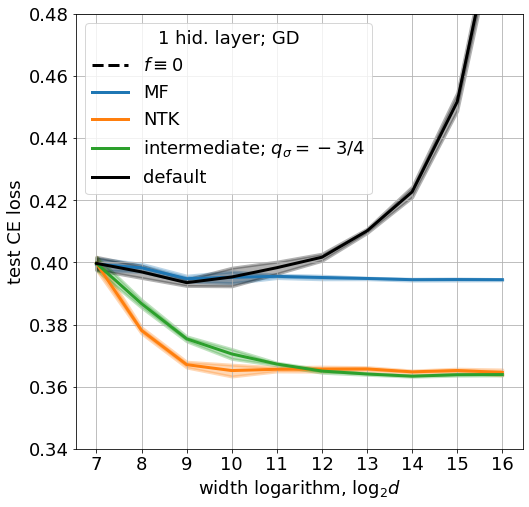

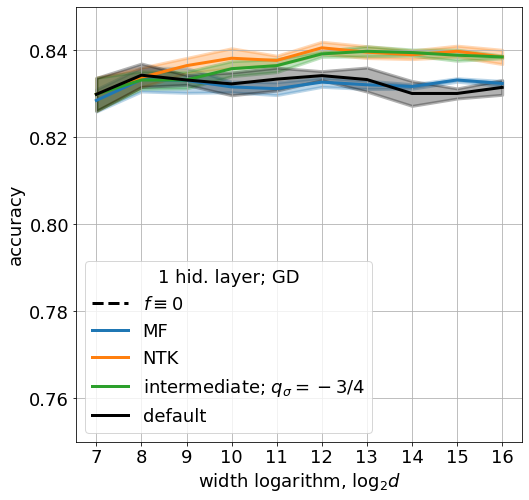

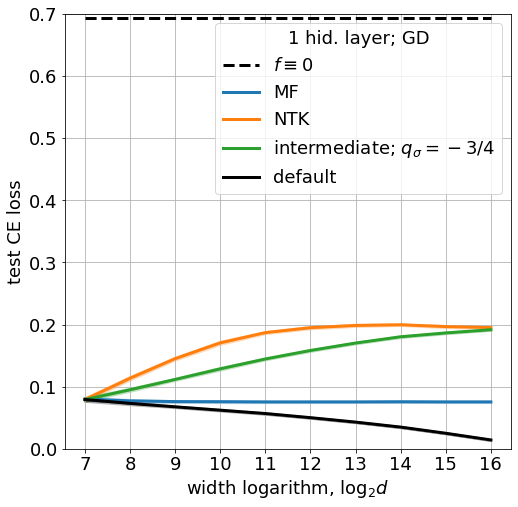

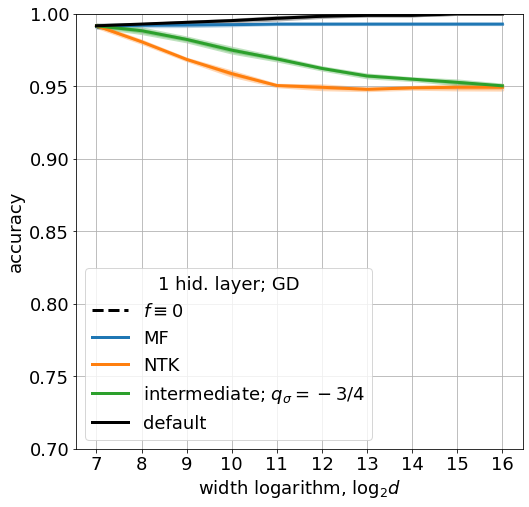

In [1898]:
for key_base, ylim in zip(key_bases, ylims):
    _ = plt.figure(figsize=(8,8))

#     plt.title(
#         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
#             key_base, num_hidden, activation, optimizer, lr, dataset, train_size
#         )
#     )

    plt.xlabel(r"width logarithm, $\log_2 d$")
    plt.ylim(ylim)
    plt.xticks(ticks=np.log2(real_widths))
    plt.grid(True)

    if key_base.endswith('_loss'):
        plt.ylabel("test CE loss")
        plt.plot(
            np.log2(real_widths), np.zeros_like(real_widths) + np.log(num_classes), 
            color='black', lw=3, ls='dashed'
       )
    elif key_base.endswith('_acc'):
        plt.ylabel("accuracy")
        plt.plot(
            np.log2(real_widths), np.zeros_like(real_widths) + 1 / num_classes, 
            color='black', lw=3, ls='dashed'
        )

    for ref_width in ref_widths[:1]:
        for k, scaling_mode in enumerate(scaling_modes):
            if scaling_mode == 'default':
                ref_width = None
                if not show_default:
                    continue
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', 
                                   linestyle='solid', lw=3)
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, color=cmap(k), 
                            linestyle=linestyles[i], lw=3
                        )
                    
    plt.legend(
        [r'$f \equiv 0$'] + 
        [mode_name for mode_name in scaling_mode_names if mode_name != 'default' or show_default],
        title='{} hid. layer{}; {}'.format(num_hidden, 's' if num_hidden > 1 else '', optimizer_name)
    )
    plt.show()

In [1899]:
def draw_ref_width_dependence(scaling_mode, correction_epoch, key, 
                              threshold=1000, **kwargs):
    data_ref = [
        [
            results_all[scaling_mode][ref_width][correction_epoch][ref_width][seed][key] 
            for ref_width in ref_widths
        ] for seed in range(num_seeds)
    ]
    data_lim = [
        [
            results_all[scaling_mode][ref_width][correction_epoch][real_widths[-1]][seed][key] 
            for ref_width in ref_widths
        ] for seed in range(num_seeds)
    ]
    data_ref = np.array(data_ref)
    data_lim = np.array(data_lim)
    data_ref = np.clip(data_ref, -threshold, threshold)
    data_lim = np.clip(data_lim, -threshold, threshold)
    data_ref_mean = data_ref.mean(axis=0)
    data_lim_mean = data_lim.mean(axis=0)
    data = data_lim_mean - data_ref_mean
    plt.plot(np.log2(ref_widths), data, **kwargs)
        

In [1900]:
ylims = [(-0.02, 0.02), (-0.01, 0.01), (-0.2, 0.2), (-0.01, 0.01)]

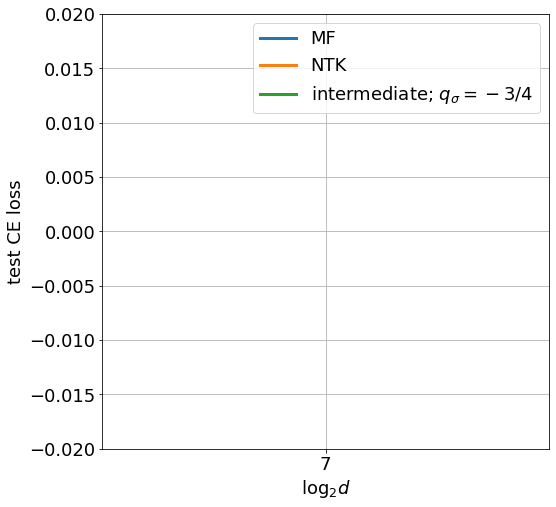

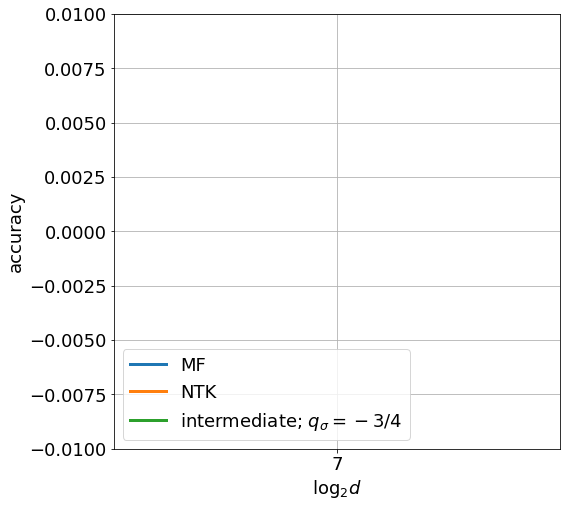

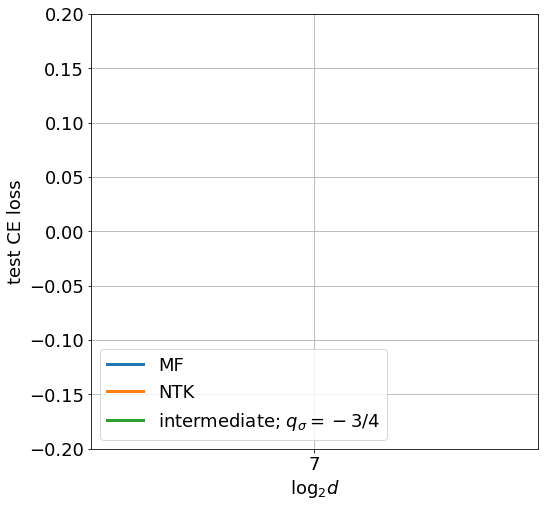

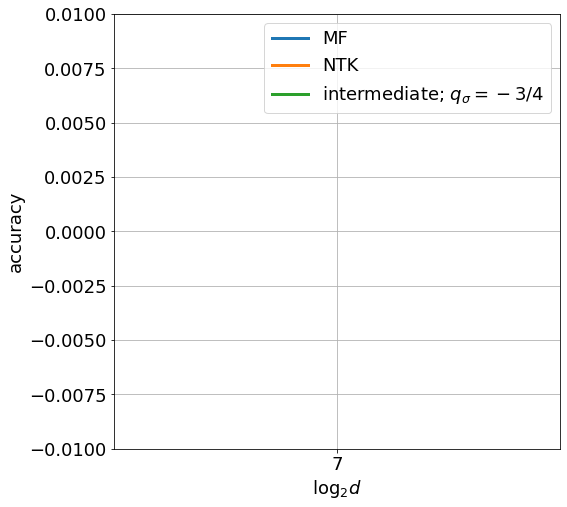

In [1901]:
for key_base, ylim in zip(key_bases, ylims):
    _ = plt.figure(figsize=(8,8))

    plt.xlabel(r"$\log_2 d$")
    plt.ylim(ylim)
    plt.xticks(ticks=np.log2(ref_widths))
    plt.grid(True)
    
    if key_base.endswith('_loss'):
        plt.ylabel("test CE loss")
#         plt.plot(
#             np.log2(real_widths), np.zeros_like(real_widths) + np.log(num_classes), 
#             color='black', lw=3, ls='solid'
#         )
    elif key_base.endswith('_acc'):
        plt.ylabel("accuracy")
#         plt.plot(
#             np.log2(real_widths), np.zeros_like(real_widths) + 1 / num_classes, 
#             color='black', lw=3, ls='solid'
#         )

    for k, scaling_mode in enumerate(scaling_modes):
        if scaling_mode == 'default':
            continue
        for correction_epoch in (
            correction_epochs if scaling_mode.startswith('mean_field') else [None]
        ):
            if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                continue
            for i, key_mod in enumerate(key_modifiers):
                key = key_mod[0] + key_base + key_mod[1]
                draw_ref_width_dependence(
                    scaling_mode, correction_epoch, key, color=cmap(k), 
                    linestyle=linestyles[i], lw=3
                )
                    
    plt.legend(scaling_mode_names)
    plt.show()

In [1902]:
key_bases = ['test_loss']
key_modifiers = [('final_', '_'), ('final_', '_a'), ('final_', '_w'), ('final_', '_avw'), ('init_', ''), ]
ylims = [(0.35,0.72), (0.5, 1.0), (0.0,0.72), (0.5,1.0)]

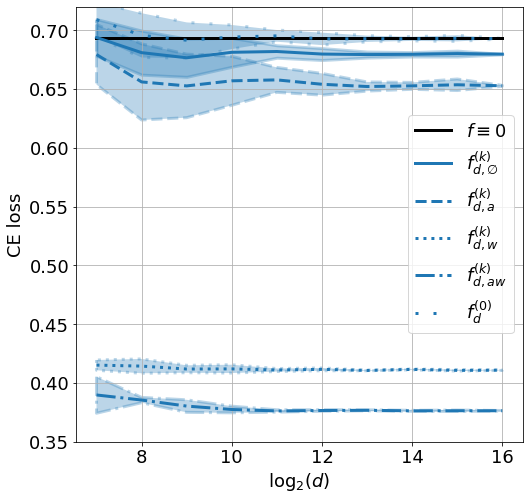

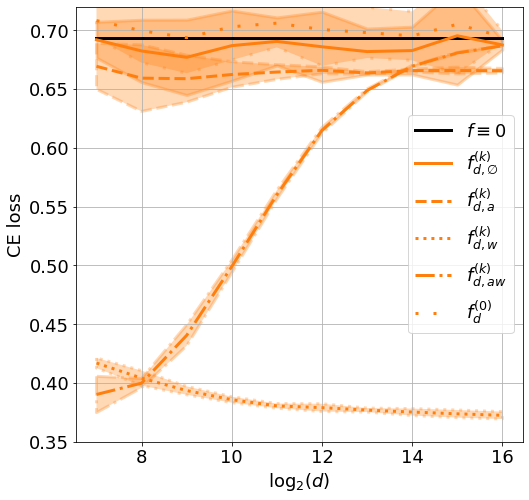

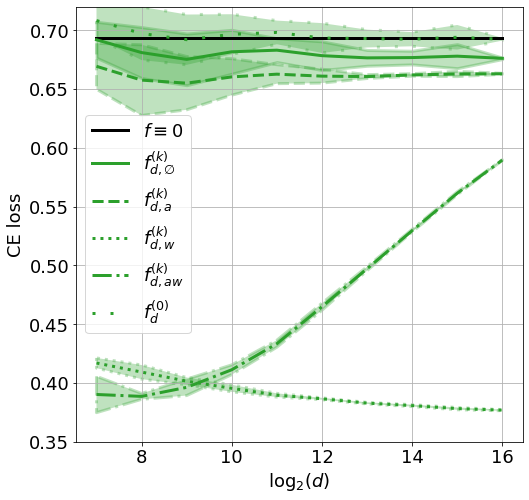

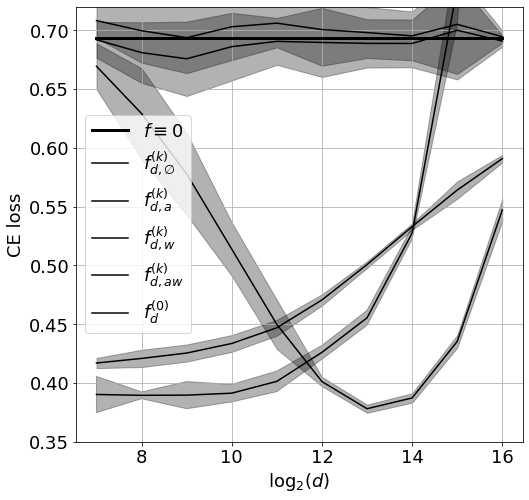

In [1903]:
for key_base, ylim in zip(key_bases, ylims):
    for k, scaling_mode in enumerate(scaling_modes):
        _ = plt.figure(figsize=(8,8))

    #     plt.title(
    #         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
    #             key_base, num_hidden, activation, optimizer, lr, dataset, train_size
    #         )
    #     )

        plt.xlabel(r"$\log_2(d)$")
        plt.ylim(ylim)
        plt.grid(True)

        if key_base.endswith('_loss'):
            plt.ylabel("CE loss")
            plt.plot(
                np.log2(real_widths), np.zeros_like(real_widths) + np.log(num_classes), 
                color='black', lw=3, ls='solid'
            )
        elif key_base.endswith('_acc'):
            plt.ylabel("accuracy")
            plt.plot(
                np.log2(real_widths), np.zeros_like(real_widths) + 1 / num_classes, 
                color='black', lw=3, ls='solid'
            )

        for ref_width in (ref_widths[-1:] if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', linestyle='solid')
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, color=cmap(k), 
                            linestyle=linestyles[i], lw=3
                        )
                    
        plt.legend(
            [r'$f \equiv 0$'] +
            [
                '{}'.format(f_name) 
                for f_name in [r'$f_{d,\emptyset}^{(k)}$', r'$f_{d,a}^{(k)}$', r'$f_{d,w}^{(k)}$', r'$f_{d,aw}^{(k)}$', r'$f_d^{(0)}$']
            ]
        )
        plt.show()

In [1904]:
def compute_q(scaling_mode, ref_width, correction_epoch, key, idx=None, d_seg_len=3, **kwargs):
    if idx is None:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] for real_width in real_widths] for seed in range(num_seeds)]
    else:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx] for real_width in real_widths] for seed in range(num_seeds)]
    data = np.array(data)
#     if scaling_mode == 'default':
#         print(data)
    data_mean = data.mean(axis=0)
    q = np.log2(data_mean[-1] / data_mean[-1-d_seg_len]) / d_seg_len
    return q

In [1905]:
key_bases = ['var_f']
if num_hidden == 3:
    key_modifiers = [
        ('final_', '_'), 
        #('final_', '_a'), 
        ('final_', '_v'), 
        ('final_', '_w'), 
        ('final_', '_vw'),
        ('final_', '_aw'),
        #('final_', '_av'),
        ('final_', '_avw'),
    ]
    f_names = [
        r'$Var_x f_{d,\emptyset}^{(k)}(x)$', 
        #r'$Var_x f_{d,a}^{(k)}(x)$', 
        r'$Var_x f_{d,v^1v^2}^{(k)}(x)$', 
        r'$Var_x f_{d,w}^{(k)}(x)$', 
        r'$Var_x f_{d,v^1v^2w}^{(k)}(x)$',
        r'$Var_x f_{d,aw}^{(k)}(x)$',
        #r'$Var_x f_{d,av}^{(k)}(x)$',
        r'$Var_x f_{d,av^1v^2w}^{(k)}(x)$',
    ]
elif num_hidden == 2:
    key_modifiers = [
        ('final_', '_'), 
        #('final_', '_a'), 
        ('final_', '_v'), 
        ('final_', '_w'), 
        ('final_', '_vw'),
        ('final_', '_aw'),
        #('final_', '_av'),
        ('final_', '_avw'),
    ]
    f_names = [
        r'$Var_x f_{d,\emptyset}^{(k)}(x)$', 
        #r'$Var_x f_{d,a}^{(k)}(x)$', 
        r'$Var_x f_{d,v}^{(k)}(x)$', 
        r'$Var_x f_{d,w}^{(k)}(x)$', 
        r'$Var_x f_{d,vw}^{(k)}(x)$',
        r'$Var_x f_{d,aw}^{(k)}(x)$',
        #r'$Var_x f_{d,av}^{(k)}(x)$',
        r'$Var_x f_{d,avw}^{(k)}(x)$',
    ]
elif num_hidden == 1:
    key_modifiers = [
        ('final_', '_'), 
        ('final_', '_a'), 
        ('final_', '_w'), 
        ('final_', '_avw'),
    ]
    f_names = [
        r'$Var_x f_{d,\emptyset}^{(k)}(x)$', 
        r'$Var_x f_{d,a}^{(k)}(x)$', 
        r'$Var_x f_{d,w}^{(k)}(x)$', 
        r'$Var_x f_{d,aw}^{(k)}(x)$'
    ]
else:
    raise NotImplementedError

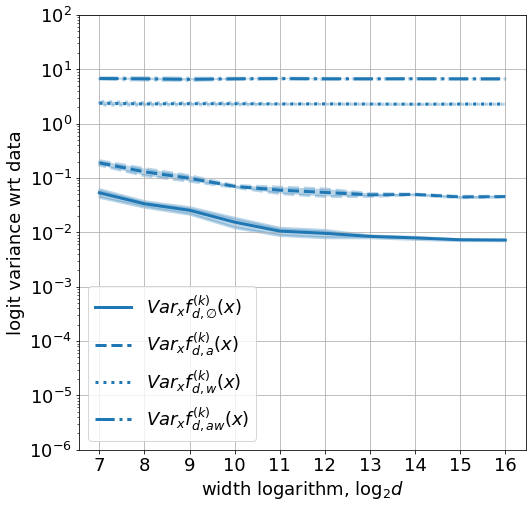

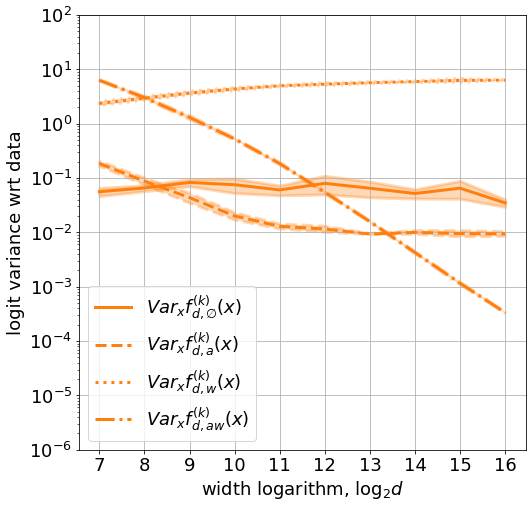

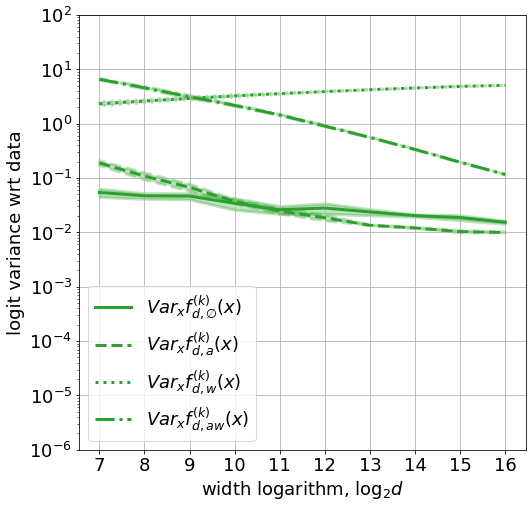

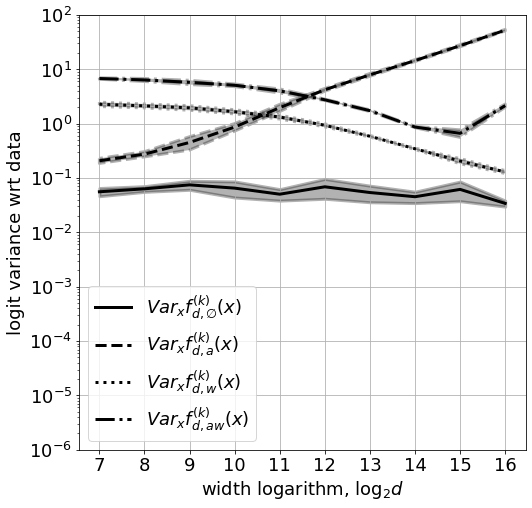

In [1906]:
for key_base, ylim in zip(key_bases, ylims):
    for k, scaling_mode in enumerate(scaling_modes):
        _ = plt.figure(figsize=(8,8))

        plt.xlabel(r"width logarithm, $\log_2 d$")
        plt.ylabel('logit variance wrt data')
        plt.ylim((1e-6,1e2))
        plt.yscale('log')
        plt.grid(True)
        plt.xticks(ticks=np.log2(real_widths))
        
        qs = []

        for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    idx = None
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', 
                                   linestyle=linestyles[i], lw=3, smoothening_factor=0.1)
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, idx=idx, color=cmap(k), 
                            linestyle=linestyles[i], lw=3, smoothening_factor=0.1
                        )
                    #qs.append(compute_q(scaling_mode, ref_width, correction_epoch, key, idx=idx, d_seg_len=2) / 2)
                    
#         plt.legend(
#             [
#                 '{}; q_emp = {:.2f}'.format(f_name, q) 
#                 for f_name, q in zip(f_names, qs)
#             ]
#         )
        plt.legend(f_names)
        plt.show()

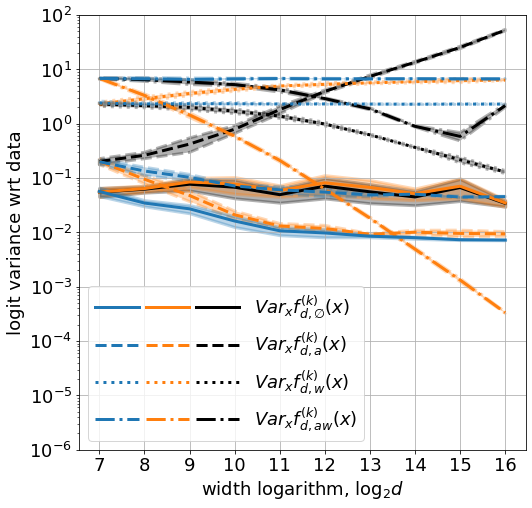

In [1907]:
show_intermediate = False

for ref_width in ref_widths:
    _ = plt.figure(figsize=(8,8))

    plt.xlabel(r"width logarithm, $\log_2 d$")
    plt.ylabel('logit variance wrt data')
    plt.ylim((1e-6,1e2))
    plt.yscale('log')
    plt.grid(True)
    plt.xticks(ticks=np.log2(real_widths))
    
    plots = {}

    for key_base, ylim in zip(key_bases, ylims):
        for k, scaling_mode in list(enumerate(scaling_modes))[::-1]:
            if scaling_mode == 'default' and not show_default:
                continue
            if scaling_mode.startswith('intermediate') and not show_intermediate:
                continue
                
            plots[scaling_mode] = {}

            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    idx = None
                    if scaling_mode == 'default':
                        plots[scaling_mode][key_mod] = draw_curve(
                            scaling_mode, None, correction_epoch, key, color='black', 
                            linestyle=linestyles[i], lw=3, smoothening_factor=0.
                        )
                    else:
                        plots[scaling_mode][key_mod] = draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, idx=idx, color=cmap(k), 
                            linestyle=linestyles[i], lw=3, smoothening_factor=0.
                        )

    plt.legend(
        [
            tuple(
                [
                    plots[scaling_mode][key_mod] for scaling_mode in scaling_modes 
                    if (scaling_mode != 'default' or show_default) and 
                    (not scaling_mode.startswith('intermediate') or show_intermediate)
                ]
            ) 
            for key_mod in key_modifiers
        ],
        f_names, handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=8
    )
    plt.show()

In [1908]:
def draw_q_barplot(
    scaling_mode, ref_width, correction_epoch, keys, plot_count=1, plot_idx=0, 
    d_seg_len=2, total_width=0.8, smoothening_factor=0, q_factor=1, q=0, idx=None, **kwargs
):
    width = total_width / plot_count
    if idx is None:
        data = [
            [
                [
                    results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] 
                    for key in keys
                ] for real_width in real_widths
            ] for seed in range(num_seeds)
        ]
    else:
        data = [
            [
                [
                    results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx] 
                    for key in keys
                ] for real_width in real_widths
            ] for seed in range(num_seeds)
        ]
    data = np.array(data)
    data = np.transpose(
        np.exp(ewma(np.log(np.transpose(data, axes=(1,0,2)))[::-1], alpha=1-smoothening_factor))[::-1], 
        axes=(1,0,2)
    )
    data_mean = data.mean(axis=0)
    qs = np.log2(data_mean[len(real_widths)-1] / data_mean[len(real_widths)-1-d_seg_len]) / d_seg_len + q
    xs = np.arange(len(qs))
    plt.bar(xs + width * (plot_idx*2 - plot_count + 1) / 2, qs * q_factor, width=width, **kwargs)

In [1909]:
def draw_q_th_barplot(
    scaling_mode, keys, plot_count=1, plot_idx=0, 
    total_width=0.8, h=0.02, **kwargs
):
    width = total_width / plot_count
    qs = []
    if num_hidden == 1:
        for key in keys:
            if scaling_mode == 'mean_field':
                if key.endswith('_'):
                    q = 0
                elif key.endswith('_a'):
                    q = 0
                elif key.endswith('_w'):
                    q = 0
                elif key.endswith('_aw'):
                    q = 0
                elif key == 'input_weight_mean_abs_inc':
                    q = 0
                elif key == 'output_weight_mean_abs_inc':
                    q = 0
                else:
                    raise ValueError
            elif scaling_mode == 'ntk':
                if key.endswith('_'):
                    q = 0
                elif key.endswith('_a'):
                    q = 0
                elif key.endswith('_w'):
                    q = 0
                elif key.endswith('_aw'):
                    q = -1
                elif key == 'input_weight_mean_abs_inc':
                    q = -1/2
                elif key == 'output_weight_mean_abs_inc':
                    q = -1/2
                else:
                    raise ValueError
            elif scaling_mode == 'intermediate_q=0.75':
                if key.endswith('_'):
                    q = -0.25
                elif key.endswith('_a'):
                    q = 0
                elif key.endswith('_w'):
                    q = 0
                elif key.endswith('_aw'):
                    q = -0.5
                elif key == 'input_weight_mean_abs_inc':
                    q = -1/4
                elif key == 'output_weight_mean_abs_inc':
                    q = -1/4
                else:
                    raise ValueError
            elif scaling_mode == 'default':
                return
            else:
                raise ValueError
            qs.append(q)
    else:
        return
                
    xs = np.arange(len(qs))
    qs = np.array(qs)
    plt.bar(xs + width * (plot_idx*2 - plot_count + 1) / 2, h, bottom=qs-h/2, width=width, **kwargs)

In [1910]:
key_bases = ['var_f']
if num_hidden == 3:
    key_modifiers = [
        ('final_', '_'), 
        ('final_', '_a'), 
        ('final_', '_v'), 
        ('final_', '_w'), 
        ('final_', '_vw'),
        ('final_', '_aw'),
        ('final_', '_av'),
        ('final_', '_avw'),
    ]
    f_names = [
        r'$q_{f,\emptyset}^{(k)}$', 
        r'$q_{f,a}^{(k)}$', 
        r'$q_{f,v^{1,2}}^{(k)}$', 
        r'$q_{f,w}^{(k)}$', 
        r'$q_{f,v^{1,2}w}^{(k)}$',
        r'$q_{f,aw}^{(k)}$',
        r'$q_{f,av^{1,2}}^{(k)}$',
        r'$q_{f,av^{1,2}w}^{(k)}$',
    ]
elif num_hidden == 2:
    key_modifiers = [
        ('final_', '_'), 
        ('final_', '_a'), 
        ('final_', '_v'), 
        ('final_', '_w'), 
        ('final_', '_vw'),
        ('final_', '_aw'),
        ('final_', '_av'),
        ('final_', '_avw'),
    ]
    f_names = [
        r'$q_{f,\emptyset}^{(k)}$', 
        r'$q_{f,a}^{(k)}$', 
        r'$q_{f,v}^{(k)}$', 
        r'$q_{f,w}^{(k)}$', 
        r'$q_{f,vw}^{(k)}$',
        r'$q_{f,aw}^{(k)}$',
        r'$q_{f,av}^{(k)}$',
        r'$q_{f,avw}^{(k)}$',
    ]
elif num_hidden == 1:
    key_modifiers = [
        ('final_', '_'), 
        ('final_', '_a'), 
        ('final_', '_w'), 
        ('final_', '_aw'),
    ]
    f_names = [
        r'$q_{f,\emptyset}^{(k)}$', 
        r'$q_{f,a}^{(k)}$', 
        r'$q_{f,w}^{(k)}$', 
        r'$q_{f,aw}^{(k)}$',
    ]
else:
    raise NotImplementedError

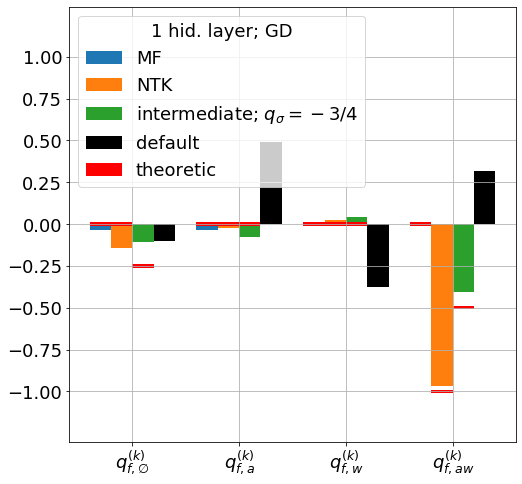

In [1912]:
for key_base, ylim in zip(key_bases, ylims):
    _ = plt.figure(figsize=(8,8))

    #plt.xlabel(r"$\log_2(d)$")
    plt.ylim((-2**(num_hidden-1)-0.3,2**(num_hidden-1)+0.3))
    #plt.yscale('log')
    plt.grid(True)
        
    keys = []
    for key_mod in key_modifiers:
        keys.append(key_mod[0] + key_base + key_mod[1])

    for k, scaling_mode in enumerate(scaling_modes):
        for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                if scaling_mode == 'default':
                    draw_q_barplot(
                        scaling_mode, ref_width, correction_epoch, keys, 
                        plot_idx=k, plot_count=len(scaling_modes), color='black', d_seg_len=2,
                        smoothening_factor=0., q_factor=0.5
                    )
                else:
                    draw_q_barplot(
                        scaling_mode, ref_width, correction_epoch, keys, 
                        plot_idx=k, plot_count=len(scaling_modes), color=cmap(k), d_seg_len=2,
                        smoothening_factor=0., q_factor=0.5
                    )
                    
    for k, scaling_mode in enumerate(scaling_modes):
        for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                draw_q_th_barplot(
                    scaling_mode, keys, 
                    plot_idx=k, plot_count=len(scaling_modes), color='red'
                )
                    
    plt.xticks(ticks=np.arange(len(f_names)), labels=f_names)
    plt.yticks(ticks=np.arange(-2**(num_hidden-1),2**(num_hidden-1) + 0.1, 2**(num_hidden-3)))

    plt.legend(
        scaling_mode_names + ['theoretic'], 
        title='{} hid. layer{}; {}'.format(num_hidden, 's' if num_hidden > 1 else '', optimizer_name)
    )
    #plt.ylim()
    

In [1740]:
if num_hidden > 1:
    keys = ['output_weight_mean_abs_inc', 'hidden_weight_mean_abs_inc', 'intput_weight_mean_abs_inc']
    key_names = [
        r'$|\delta \hat a^{(k)}|$',
        r'$|\delta \hat v^{(k)}|$', 
        r'$\|\delta \hat\mathbf{w}^{(k)}\|$', 
    ]
    # key_names = [
    #     r'$\|\delta \hat\mathbf{w}^{(k)}\| / d^{q_w^{(k)}}$', 
    #     r'$|\delta \hat v^{(k)}| / d^{q_v^{(k)}}$', 
    #     r'$|\delta \hat a^{(k)}| / d^{q_a^{(k)}}$'
    # ]
else:
    keys = ['output_weight_mean_abs_inc', 'input_weight_mean_abs_inc']
    key_names = [
        r'$|\delta \hat a^{(k)}|$',
        r'$\|\delta \hat\mathbf{w}^{(k)}\|$', 
    ]
    # key_names = [
    #     r'$\|\delta \hat\mathbf{w}^{(k)}\| / d^{q_w^{(k)}}$', 
    #     r'$|\delta \hat a^{(k)}| / d^{q_a^{(k)}}$'
    # ]


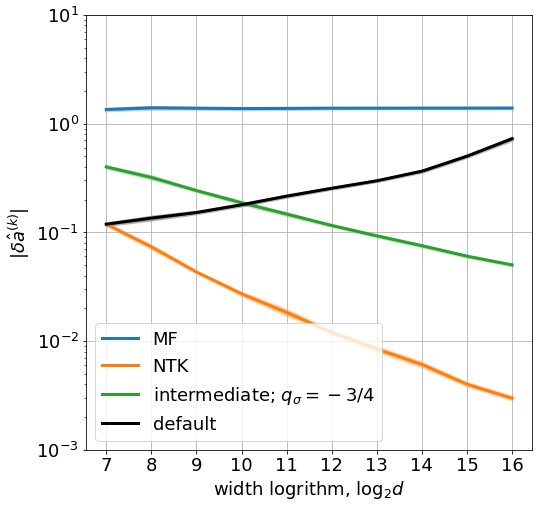

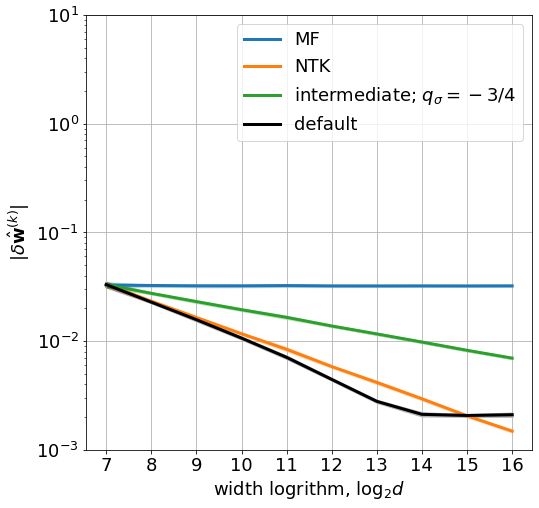

In [1650]:
for i, (key_name, key) in enumerate(zip(key_names, keys)):
    _ = plt.figure(figsize=(8,8))

#     plt.title(
#         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
#             key_name, num_hidden, activation, optimizer, lr, dataset, train_size
#         )
#     )

    plt.xlabel(r"width logrithm, $\log_2 d$")
    #plt.ylabel('average {} weight increment, {}'.format(key.split('_')[0], key_name))
    plt.ylabel(key_name)
    plt.xticks(ticks=np.log2(real_widths))
    plt.grid(True)
    
    for idx in (range(num_hidden-1) if key == 'hidden_weight_mean_abs_inc' else [None]):
        for k, scaling_mode in enumerate(scaling_modes):
            if scaling_mode == 'default' and not show_default:
                continue
            if num_hidden == 1:
                if scaling_mode == 'mean_field':
                    q = [1, 0][i]
                elif scaling_mode == 'ntk':
                    q = [0.5, 0.][i]
                elif scaling_mode == 'intermediate_q=0.75':
                    q = [0.75, 0.][i]
                elif scaling_mode == 'default':
                    q = [0.5, 0.][i]
                else:
                    raise ValueError
            else:
                if scaling_mode == 'mean_field':
                    q = [1, 1, 0][i]
                elif scaling_mode == 'ntk':
                    q = [0.5, 0.5, 0.][i]
                elif scaling_mode == 'intermediate_q=0.75':
                    q = [0.75, 0.75, 0.][i]
                elif scaling_mode == 'default':
                    q = [0.5, 0.5, 0.][i]
                else:
                    raise ValueError
            for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
                for correction_epoch in (
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    if scaling_mode == 'default':
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, 
                            q=q, idx=idx, color='black', linestyle='solid', lw=3
                        )
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, 
                            q=q, idx=idx, color=cmap(k), 
                            linestyle='solid', lw=3
                        )

    plt.legend([mode_name for mode_name in scaling_mode_names if mode_name != 'default' or show_default])
    plt.yscale('log')
    plt.ylim((1e-3,1e1))
    #plt.ylim(bottom=0)
    plt.show()

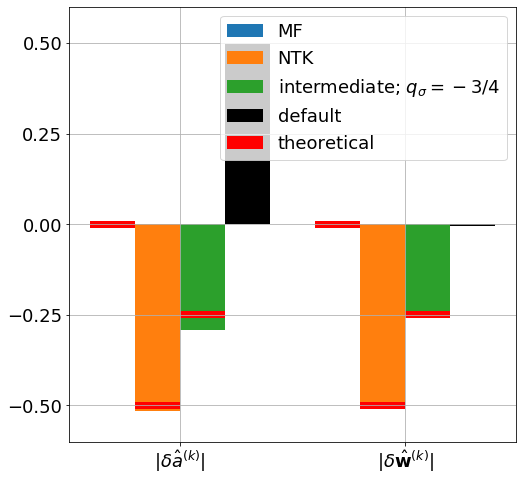

In [1651]:
_ = plt.figure(figsize=(8,8))

#     plt.title(
#         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
#             key_name, num_hidden, activation, optimizer, lr, dataset, train_size
#         )
#     )

#plt.xlabel(r"$\log_2 d$")
#plt.ylabel(key_name)
#plt.xticks(ticks=np.log2(real_widths))
plt.grid(True)

for k, scaling_mode in enumerate(scaling_modes):
    if scaling_mode == 'default' and not show_default:
        continue
    if num_hidden == 1:
        if scaling_mode == 'mean_field':
            q = [1, 0]
        elif scaling_mode == 'ntk':
            q = [0.5, 0.]
        elif scaling_mode == 'intermediate_q=0.75':
            q = [0.75, 0.]
        elif scaling_mode == 'default':
            q = [0.5, 0.]
        else:
            raise ValueError
    else:
        raise ValueError
    q = np.array(q)
    
    for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
        for correction_epoch in (
            correction_epochs if scaling_mode.startswith('mean_field') else [None]
        ):
            if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                continue
            if scaling_mode == 'default':
                draw_q_barplot(
                    scaling_mode, ref_width, correction_epoch, keys, 
                    q=q, idx=None, plot_idx=k, plot_count=len(scaling_modes)-1+int(show_default),
                    color='black'
                )
            else:
                draw_q_barplot(
                    scaling_mode, ref_width, correction_epoch, keys, 
                    q=q, idx=None, plot_idx=k, plot_count=len(scaling_modes)-1+int(show_default),
                    color=cmap(k)
                )
                
for k, scaling_mode in enumerate(scaling_modes):
    for ref_width in (ref_widths[:1] if scaling_mode != 'default' else [None]):
        for correction_epoch in (
            correction_epochs if scaling_mode.startswith('mean_field') else [None]
        ):
            if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                continue
            if scaling_mode == 'default':
                draw_q_th_barplot(
                    scaling_mode, keys, 
                    plot_idx=k, plot_count=len(scaling_modes)-1+int(show_default),
                    color='red'
                )
            else:
                draw_q_th_barplot(
                    scaling_mode, keys, 
                    plot_idx=k, plot_count=len(scaling_modes)-1+int(show_default),
                    color='red'
                )

plt.legend([mode_name for mode_name in scaling_mode_names if mode_name != 'default' or show_default] + ['theoretical'])
#plt.yscale('log')
plt.ylim((-0.6,0.6))
plt.yticks(ticks=np.arange(-0.5,0.6,0.25))
plt.xticks(ticks=np.arange(len(keys)), labels=key_names)
plt.show()